# Beam Size Tests

**Scott Prahl**

**June 2020, Version 4**

These are all artificial tests.  A perfect astigmatic Gaussian beam is generated and then noise (and/or and offset) is added to the entire image.  Examples are shown in which the default algorithm works perfectly and also fails spectacularly.

In [1]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import laserbeamsize as lbs

def side_by_side_plot(h,v,xc,yc,dx,dy,phi,noise=0,offset=0):
    print(np.degrees(phi))
    test = lbs.beam_test_image(h,v,xc,yc,dx,dy,phi,noise=noise)
    xc_found, yc_found, dx_found, dy_found, phi_found = lbs.beam_size(test)
    print(np.degrees(phi))


    plt.subplots(1,2,figsize=(12,5))
    plt.subplot(1,2,1)
    plt.imshow(test,cmap='gray')
    plt.plot(xc,yc,'ob',markersize=2)
    plt.title('Original (%d,%d), dx=%.0f, dy=%.0f, $\phi$=%.0f°' % (xc,yc,dx,dy,np.degrees(phi)))

    plt.subplot(1,2,2)
    plt.imshow(test,cmap='gray')
    xp,yp = lbs.rotated_rect_arrays(xc_found, yc_found, dx_found, dy_found, phi_found)
    plt.plot(xp,yp,':y')
    plt.plot(xc_found,yc_found,'ob',markersize=2)
    plt.title('Found (%d,%d), dx=%.0f, dy=%.0f, $\phi$=%.0f°' % (xc_found,yc_found,dx_found,dy_found,np.degrees(phi_found)))



## The problem of background

### Recall the definition for beam center

As mentioned in the literature, image artifacts outside the beam can cause dramatic errors when the ISO 11146 algorithm is used.  Consider just finding the 
center in the horizontal direction.  We calculate the total power $P$ over the entire image of the beam

$$
P = \sum_{i=0}^{N-1} \sum_{j=0}^{M-1} E_{ij}
$$

and then locate the center of this beam with the following sum (that approximates the weighted integral)

$$
x_c \approx {1\over P} \sum_{i=0}^{N-1} \sum_{j=0}^{M-1} i \cdot E_{ij}
$$

Now if the image is zero outside the beam, the $E_{ij}=0$ for those pixels and these contribute *nothing* in either of the sums above.  

### Constant backgroud

In the case constant background with a value equal $\varepsilon P$, 

$$
E_{ij}=E'_{ij} + \varepsilon P
$$ 

The calculation of $x_c$ becomes
$$
x_c \approx \frac{1}{P'} \sum_{i=0}^{N-1} \sum_{j=0}^{M-1} i E'_{ij} +  \frac{\varepsilon N(N-1)M P}{2P'} \approx
\frac{1}{P'} \sum_{i=0}^{N-1} \sum_{j=0}^{M-1} i E'_{ij} + \varepsilon\frac{N^2M}{2} 
$$

Because the last term is always positive, the predicted center of the beam will 

* always be displaced to the right!
* have a greater error for greater image sizes
* be very sensitive to extra horizonal width

So, extra *background* across the image is problematic for locating the beam center.  Ideally, background image noise  would just be replaced with zeros.  

### Dealing with background

The `lbs.beam_size()` algorithm should work robustly for a variety of images.  However some images just have noise.

There are many ways to pre-process the image.

1. subtract a background image (no beam) from the image with beam

2. subtract a threshold value from all pixels

3. subtract the average value found in the corners of the image

4. some crazy statistical method involving convolution

#### Background image

Best practice, of course, is to gather more data.  Capture an image with the beam off and then one with the beam on.
Subtract the two.  `lbs.subtract_image(image,background)` makes this simple and avoids possible "wrap-around" in unsigned pixel values when negative numbers arise — they are just set to zero.

#### Subtracting a constant threshold value

Three choices for a threshold value are possible

1. The minimum value in image from the image before processing.  Unfortunately, in real images, the minimum value tends to be close to zero and very little background is removed.  This is usually unhelpful.

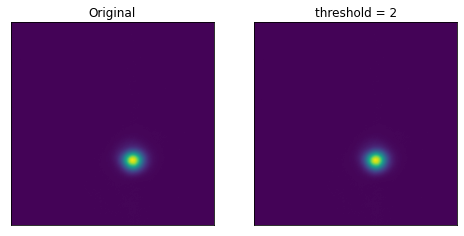

In [2]:
test = imageio.imread("t-666mm.pgm")

plt.subplots(1,2,figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(test)
plt.xticks([])
plt.yticks([])
plt.title('Original')

plt.subplot(1,2,2)

threshold = np.min(test)
s = lbs.subtract_threshold(test, threshold)
plt.imshow(s)
plt.xticks([])
plt.yticks([])
plt.title('threshold = %d' % threshold)

plt.show()

2. Some fraction $f_{th}$ of the maximum value $E_{max}$ in the image.  The idea is to subtract $c=E_{max}\cdot f_{th}$ across the entire image.  The `lbs.subtract_threshold(image,c)` does this properly.

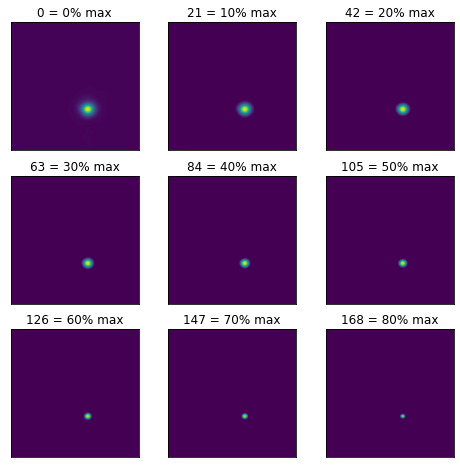

In [3]:
test = imageio.imread("t-666mm.pgm")

plt.subplots(3,3,figsize=(8,8))

imax = np.max(test)
for i in range(9):
    plt.subplot(3,3,i+1)
    threshold = int(i/10*imax)
    s = lbs.subtract_threshold(test, threshold)
    plt.imshow(s)
    plt.xticks([])
    plt.yticks([])
    plt.title('%d = %.0f%% max' % (threshold, i*10))

plt.show()

3. Use rectangles in the corners of the image to estimate the mean and stdev. of the pixels in the background. Then subtract a $c=\mathrm{mean}+n_T\cdot\mathrm{stdev}$ from the image.  ISO 11146-3 suggests $2<n_T<4$, the algorithm `lbs.corner_subtract(image)` defaults to $n_T=3$.  The size of the rectangle in each corner defaults to 3.5% of the size of the entire image.  This is shown below.

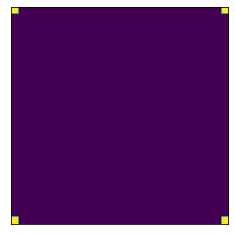

the average in the corners is 4 gray levels
the std dev in the corners is 5 gray levels
the default corner threshold will be 18 gray levels


In [4]:
test = imageio.imread("t-666mm.pgm")
back = lbs.corner_mask(test)
plt.imshow(back)
plt.xticks([])
plt.yticks([])
plt.show()

mean,stdev = lbs.corner_background(test)
print("the average in the corners is %.0f gray levels" % mean)
print("the std dev in the corners is %.0f gray levels" % stdev)
print("the default corner threshold will be %.0f gray levels" % (mean+3*stdev))

Now remove the estimate of the background obtained from the corners.

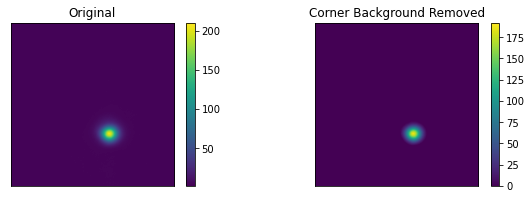

In [5]:
test = imageio.imread("t-666mm.pgm")

plt.subplots(1,2,figsize=(10,3))

plt.subplot(1,2,1)
plt.imshow(test)
plt.title('Original')
plt.xticks([])
plt.yticks([])
plt.colorbar()

plt.subplot(1,2,2)
corner = lbs.corner_subtract(test)
plt.imshow(corner)
plt.title('Corner Background Removed')
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

#### Actual algorithm Used

We follow the ISO 11146-3 guidelines::

>Since the beam's centroid, orientation and widths are initially unknown, the procedure starts with an approximation for the integration area. The approximation should include the beam's extent, orientation and position. Using this integration area, initial values for the beam position, size and orientation are obtained which are used to redefine the integration area. From the new integration area, new values for the beam size, orientation and position are calculated. This procedure shall be repeated until convergence of the results is obtained.

The initial beam parameters are extracted from the entire image with the background removed (using the corner method).  New parameters are then calculated using the appropriate integration area.  The process is repeated until convergence.


## Integration Area

ISO 11146-3 states::

> All integrations ... are performed on a rectangular integration area which is centred to the beam centroid, defined by the spatial first order moments, orientated parallel to the principal axes of the power density distribution, and sized three times the beam widths $d_{\sigma x}$ and $d_{\sigma y}$...

This turned out to be surprisingly fiddly (most likely because masked numpy arrays did't work as I expected).  In the pictures that follow, the dotted rectangle shows the final integration area.

### Test 1 Centered, Horizontal, away from edges

0.0
0.0


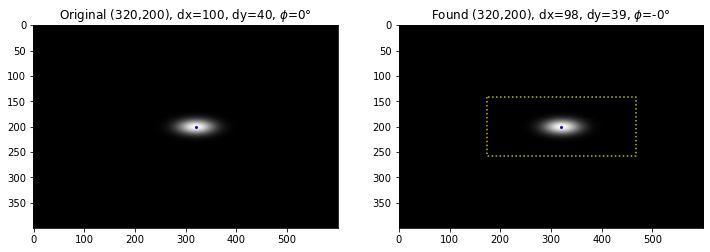

In [6]:
xc=320
yc=200
dx=100
dy=40
phi=np.radians(0)
h=600
v=400

side_by_side_plot(h,v,xc,yc,dx,dy,phi)
plt.show()

### Test 2 Corner, Horizontal

0.0
0.0


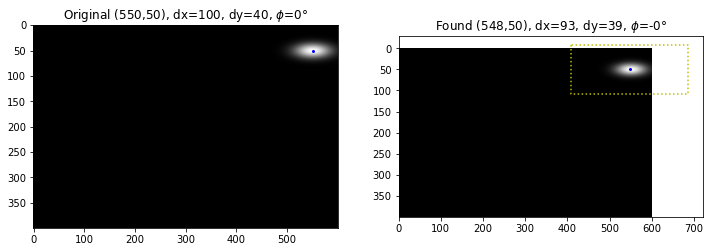

In [7]:
xc=550
yc=50

side_by_side_plot(h,v,xc,yc,dx,dy,phi)
plt.show()

### Test 3 Center, tilted 30°

29.999999999999996
29.999999999999996


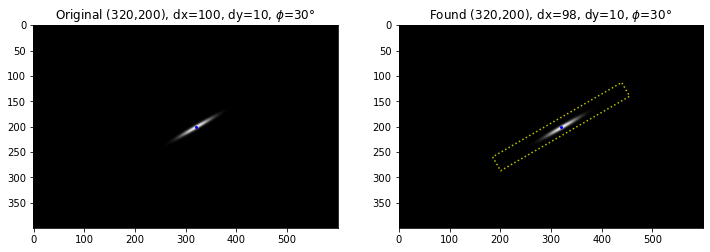

In [8]:
xc=320
yc=200
dx=100
dy=10
phi=np.radians(30)

side_by_side_plot(h,v,xc,yc,dx,dy,phi)
plt.show()

### Test 4 Corner, tilted 30°

29.999999999999996
29.999999999999996


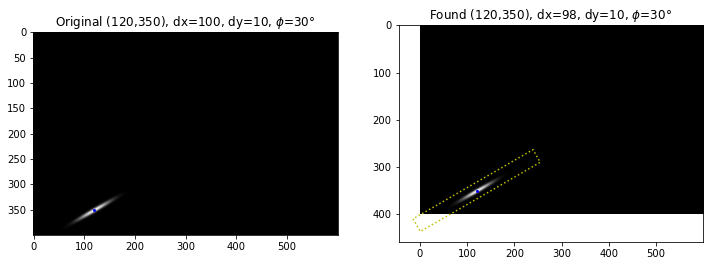

In [9]:
xc=120
yc=350

side_by_side_plot(h,v,xc,yc,dx,dy,phi)
plt.show()

### Test 5 Center, tilted 70°

70.0
70.0


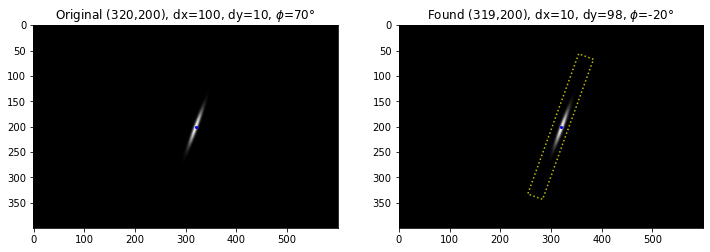

In [10]:
xc=320
yc=200
dx=100
dy=10
phi=np.radians(70)

side_by_side_plot(h,v,xc,yc,dx,dy,phi)
plt.show()

## Testing with gaussian noise

### Test 1. Simple, noise-free rotated elliptical beam

In this and all rest of the test functions, the maximum value in the test array is 256.

No gaussian noise, works fine!

20.0
20.0


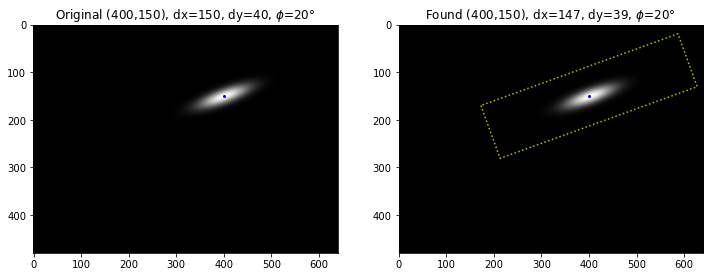

In [11]:
xc=400
yc=150
dx=150
dy=40
phi=np.radians(20)
h=640
v=480

side_by_side_plot(h,v,xc,yc,dx,dy,phi,noise=0)
plt.show()

## Test 2. Gaussian Noise 5%

Mostly works.  Widths are a bit off.

-29.999999999999996
-29.999999999999996


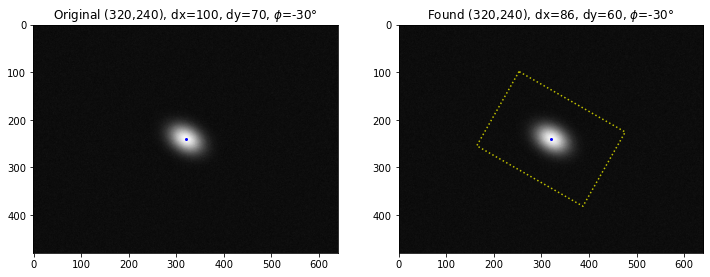

In [12]:
xc=320
yc=240
dx=100
dy=70
phi=np.radians(-30)
h=640
v=480

side_by_side_plot(h,v,xc,yc,dx,dy,phi,noise=0.05*255)
plt.show()

### Test 3: Unrotated astigmatic beam

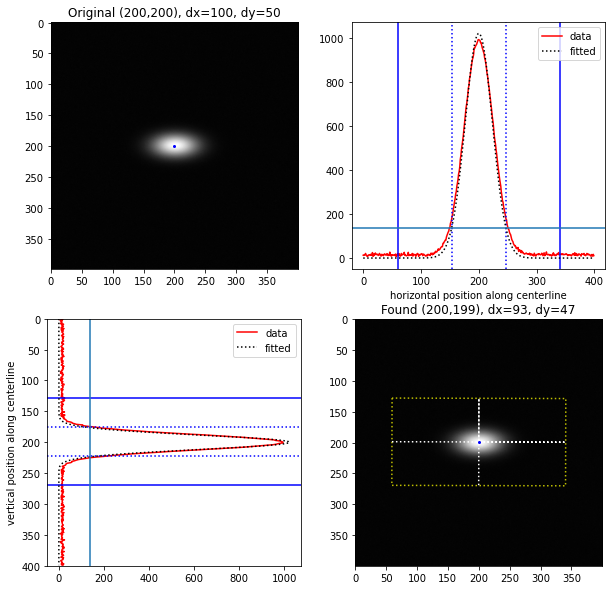

In [13]:
xc=200
yc=200
dx=100
dy=50
phi=np.radians(0)
h=400
v=400
max_value=1023

test = lbs.beam_test_image(h,v,xc,yc,dx,dy,phi,noise=15,max_value=max_value)
xc_found, yc_found, dx_found, dy_found, phi_found = lbs.beam_size(test)

plt.subplots(2,2,figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(test,cmap='gray')
plt.plot(xc,yc,'ob',markersize=2)
plt.title('Original (%d,%d), dx=%d, dy=%d' % (xc,yc,dx,dy))

plt.subplot(2,2,2)
r=dx_found/2
x=np.linspace(0,h-1,h)
plt.plot(test[yc,:],'r', label='data')
plt.axvline(xc_found+0.5*dx_found,color='blue',linestyle=':')
plt.axvline(xc_found-0.5*dx_found,color='blue',linestyle=':')
plt.axvline(xc_found+1.5*dx_found,color='blue')
plt.axvline(xc_found-1.5*dx_found,color='blue')

plt.plot(x,max_value*np.exp(-2*((x-xc)/r)**2), ':k', label='fitted')
plt.axhline(max_value*np.exp(-2))        
plt.legend()
plt.xlabel('horizontal position along centerline')


plt.subplot(2,2,3)
r=dy_found/2
y=np.linspace(0,v-1,v)
plt.plot(test[:,xc], y, 'r', label='data')
plt.axhline(yc_found+0.5*dy_found,color='blue',linestyle=':')
plt.axhline(yc_found-0.5*dy_found,color='blue',linestyle=':')
plt.axhline(yc_found+1.5*dy_found,color='blue')
plt.axhline(yc_found-1.5*dy_found,color='blue')

plt.plot(max_value*np.exp(-2*((y-yc)/r)**2),y, ':k', label='fitted')
plt.axvline(max_value*np.exp(-2))        
plt.legend()
plt.ylabel('vertical position along centerline')
plt.ylim(v,0)

plt.subplot(2,2,4)
plt.imshow(test,cmap='gray')
xp,yp = lbs.rotated_rect_arrays(xc_found, yc_found, dx_found, dy_found, phi_found)
plt.plot(xp,yp,':y')
xp,yp = lbs.axes_arrays(xc_found, yc_found, dx_found, dy_found, phi_found)
plt.plot(xp,yp,':w')

plt.plot(xc_found,yc_found,'ob',markersize=2)
plt.title('Found (%d,%d), dx=%d, dy=%d' % (xc_found, yc_found,dx_found, dy_found))
plt.show()